In [68]:
import pandas as pd
import geopandas as gpd
import h3
import h3pandas
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import numpy as np
from shapely.geometry import Polygon, Point
from typing import cast
import os

In [69]:
### Define directories and dataset names
ROOT_DIR = os.path.abspath(os.curdir)
in_path = ROOT_DIR
out_path = ROOT_DIR + "../Outputs"
region_col_name = "NAME_1"

# Shape files

In [6]:
# Coordinate and projection systems
#crs_WGS84 =CRS("EPSG:4326")    # Originan WGS84 coordinate system
#crs_proj = CRS("EPSG:24817")    # Projection system for the selected country -- see http://epsg.io/ for more info

In [70]:
admin_gdf = gpd.read_file("../shapefiles/gadm41_ECU_shp/gadm41_ECU_1.shp")
region_gdf = gpd.read_file("../shapefiles/gadm41_ECU_shp/gadm41_ECU_0.shp")
print(f"admin_gdf = {admin_gdf.crs}")

admin_gdf = EPSG:4326


# 1. Creating H3 hexagons

In [72]:
# Creating H3 hexagons

def create_hex(aoi: gpd.GeoDataFrame, resolution: int) -> gpd.GeoDataFrame:
    geom = aoi.h3.polyfill_resample(resolution).get(["geometry"])
    geom = geom.assign(h3_index=geom.index)
    geom = geom.reset_index(drop=True)
    return geom

def add_neighbors_h3(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Add H3 neighbors using the h3 library directly."""
    nei = []
    for h3_index in gdf['h3_index']:
        # Get the 6 neighbors using H3's grid_disk function
        neighbors = list(h3.grid_disk(h3_index, 1))  # ring of distance 1
        neighbors.remove(h3_index)  # Remove the center hex itself
        
        # Map H3 indexes back to DataFrame row indices
        neighbor_indices = []
        for n in neighbors:
            match = gdf[gdf['h3_index'] == n].index
            if len(match) > 0:
                neighbor_indices.append(match[0])
        
        # Pad to 6 neighbors
        neighbor_indices = np.pad(neighbor_indices, (0, 6 - len(neighbor_indices)))
        nei.append(neighbor_indices)
    
    nei = pd.DataFrame(nei, columns=[f"n{i}" for i in range(6)], index=gdf.index)
    gdf = pd.concat((gdf, nei), axis=1)
    return gdf

def feat(aoi: gpd.GeoDataFrame, hex_res: int) -> gpd.GeoDataFrame:
    geom = create_hex(aoi, hex_res)
    geom = add_neighbors_h3(geom)
    geom["index"] = geom.index
    geom = cast(gpd.GeoDataFrame, geom.dropna(axis=0, subset=["geometry"]))
    return geom

## 1.1 H3 - exagon

In [73]:
# Choose H3 resolution
# Resolution 7: ~5km hexagons
# Resolution 8: ~0.7km hexagons  
# Resolution 9: ~0.1km hexagons

size = 6 ## resolution info here https://h3geo.org/docs/core-library/restable
hexagons = feat(admin_gdf, size)
hexagons.to_file("../outputs/geoj/hex.geojson")

In [74]:
# Clipping to the borders of the admin area
join_left_df = gpd.sjoin(hexagons, admin_gdf[[region_col_name, "geometry"]], how="left")
hexagons = join_left_df[join_left_df[region_col_name].notnull()]
hexagons.head(5)

,geometry,h3_index,n0,n1,n2,n3,n4,n5,index,index_right,NAME_1
0,"POLYGON ((-79.55461 -3.18555, -79.58445 -3.206...",868f765a7ffffff,74.0,162.0,24.0,63.0,130.0,11.0,0,0,Azuay
1,"POLYGON ((-79.3249 -2.56824, -79.35465 -2.5887...",868f2bb4fffffff,318.0,83.0,136.0,180.0,337.0,292.0,1,0,Azuay
1,"POLYGON ((-79.3249 -2.56824, -79.35465 -2.5887...",868f2bb4fffffff,318.0,83.0,136.0,180.0,337.0,292.0,1,2,Cañar
2,"POLYGON ((-79.10508 -3.25907, -79.13487 -3.279...",868f7618fffffff,91.0,161.0,190.0,191.0,169.0,58.0,2,0,Azuay
3,"POLYGON ((-79.44812 -2.95905, -79.47793 -2.979...",868f76cb7ffffff,153.0,166.0,194.0,148.0,10.0,37.0,3,0,Azuay


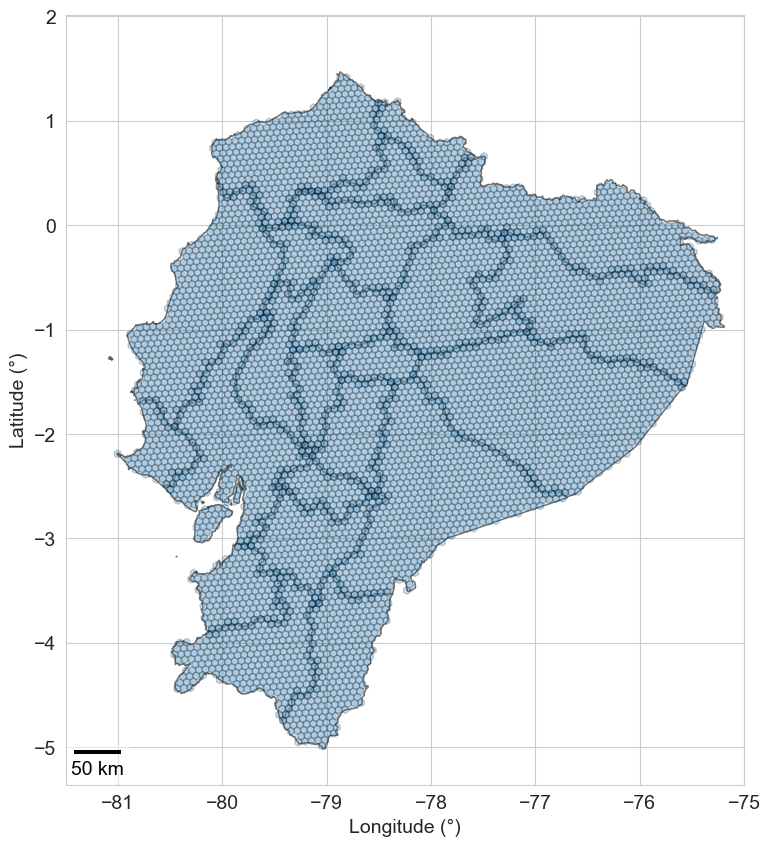

In [75]:
# Plot settings
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(12, 10))

# Plot hexagons and admin boundaries
admin_gdf.plot(ax=ax, edgecolor='black', alpha=0.2)
region_gdf.plot(ax=ax, edgecolor='black', color='None', alpha=0.4)
hexagons.plot(ax=ax, edgecolor='black', alpha=0.2)

ax.set_aspect('equal', 'box')

# Add labels
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')

# Compute distance-per-degree for ECUADOR (not New York!)
# Use two points 1 degree apart at Ecuador's approximate latitude
assert admin_gdf.crs == 'EPSG:4326'

# Ecuador center is roughly at (-78, -1)
points = gpd.GeoSeries(
    [Point(-78, -1), Point(-77, -1)], crs=4326  # 1 degree apart in longitude
)
points = points.to_crs(24817)  # UTM Zone 17S for Ecuador
distance_meters = points[0].distance(points[1])

# Add scale bar
scalebar = ScaleBar(
    distance_meters,
    dimension="si-length",
    location='lower left',
    length_fraction=0.1,
    width_fraction=0.005,
    units='m',
    color='black',
    box_alpha=0.5
)
ax.set_xlim(-81.5, -75)
ax.add_artist(scalebar)

# Save BEFORE showing
#plt.savefig('../outputs/fig/admin_level_basemap.png', bbox_inches='tight', dpi=300)

# Display the plot
plt.show()

# 2. Load RWI data and assign H3 indices

In [76]:
# Load Meta RWI data
rwi = pd.read_csv("../data/ecu_relative_wealth_index.csv")
rwi.head(5)

,latitude,longitude,rwi,error
0,-3.019841,-78.870850,0.278,0.489
1,-0.384519,-78.475342,0.585,0.522
2,-1.614776,-80.299072,-0.677,0.406
3,-0.538322,-77.091065,-0.608,0.428
4,-4.072494,-78.892822,-0.317,0.460


In [48]:
# # Choose H3 resolution
# # Resolution 7: ~5km hexagons
# # Resolution 8: ~0.7km hexagons  
# # Resolution 9: ~0.1km hexagons
# h3_res = 8

# # Assign H3 index to each RWI point
# rwi['h3_index'] = rwi.apply(
#     lambda row: h3.latlng_to_cell(row['latitude'], row['longitude'], h3_res),
#     axis=1
# )

# # Aggregate RWI to H3 hexagons
# rwi_h3 = rwi.groupby('h3_index').agg({
#     'rwi': ['mean', 'median', 'std', 'count']
# }).reset_index()

# rwi_h3.columns = ['h3_index', 'rwi_mean', 'rwi_median', 'rwi_sd', 'n_points']

# print(f"RWI aggregated to {len(rwi_h3)} H3 hexagons")
# print(rwi_h3.head())

## 2.1 Add H3 index to RWI DataFrame

In [77]:
# Choose H3 resolution
# Resolution 7: ~5km hexagons
# Resolution 8: ~0.7km hexagons  
# Resolution 9: ~0.1km hexagons
# Choose H3 resolution


# Ensure lat/lon columns exist and are numeric; drop rows with missing coords
rwi = rwi.copy()
rwi['latitude'] = pd.to_numeric(rwi['latitude'], errors='coerce')
rwi['longitude'] = pd.to_numeric(rwi['longitude'], errors='coerce')
rwi = rwi.dropna(subset=['latitude', 'longitude']).reset_index(drop=True)

# Faster: list comprehension instead of apply(axis=1)
rwi['h3_index'] = [h3.latlng_to_cell(lat, lon, size) for lat, lon in zip(rwi['latitude'], rwi['longitude'])]

# Aggregate RWI to H3 hexagons using named aggregations (no manual flattening needed)
rwi_h3 = rwi.groupby('h3_index').agg(
    rwi_mean=('rwi', 'mean'),
    rwi_median=('rwi', 'median'),
    rwi_sd=('rwi', 'std'),
    n_points=('rwi', 'count')
).reset_index()

print(f"RWI aggregated to {len(rwi_h3)} H3 hexagons")
print(rwi_h3.head())

RWI aggregated to 3386 H3 hexagons
          h3_index  rwi_mean  rwi_median    rwi_sd  n_points
0  8666c22cfffffff    -0.277      -0.297  0.095582         3
1  8666c3407ffffff    -1.195      -1.195       NaN         1
2  8666c3427ffffff    -0.652      -0.621  0.228086         3
3  8666c342fffffff    -0.647      -0.647  0.200818         2
4  8666c3437ffffff    -0.486      -0.486       NaN         1


## 2.2 Merge with hexagons GeoDataFrame

In [78]:
# hexagons: your GeoDataFrame with geometry, h3_index, NAME_1, etc.
# rwi_agg: aggregated RWI statistics by h3_index

hexagons = hexagons.merge(
    rwi_h3,
    on='h3_index',
    how='left'  # keep all hexagons, even if no RWI data
)

# Check the result
print(hexagons[['h3_index', 'NAME_1', 'rwi_mean', 'n_points']].head())

          h3_index NAME_1  rwi_mean  n_points
0  868f765a7ffffff  Azuay   -0.4052       5.0
1  868f2bb4fffffff  Azuay       NaN       NaN
2  868f2bb4fffffff  Cañar       NaN       NaN
3  868f7618fffffff  Azuay   -0.5900       1.0
4  868f76cb7ffffff  Azuay   -0.5850       2.0


In [79]:
# Two points 1 degree apart in longitude, at Ecuador's approximate latitude
# Ecuador is roughly at latitude -1 (near the equator) and longitude -78
points = gpd.GeoSeries(
    [Point(-78, -1), Point(-77, -1)], crs=4326
)  # Geographic WGS 84 - degrees

points = points.to_crs(32717)  # UTM Zone 17S for Ecuador - meters
distance_meters = points[0].distance(points[1])

print(f"1 degree of longitude at Ecuador = {distance_meters:.2f} meters")

1 degree of longitude at Ecuador = 111468.81 meters


### Plot

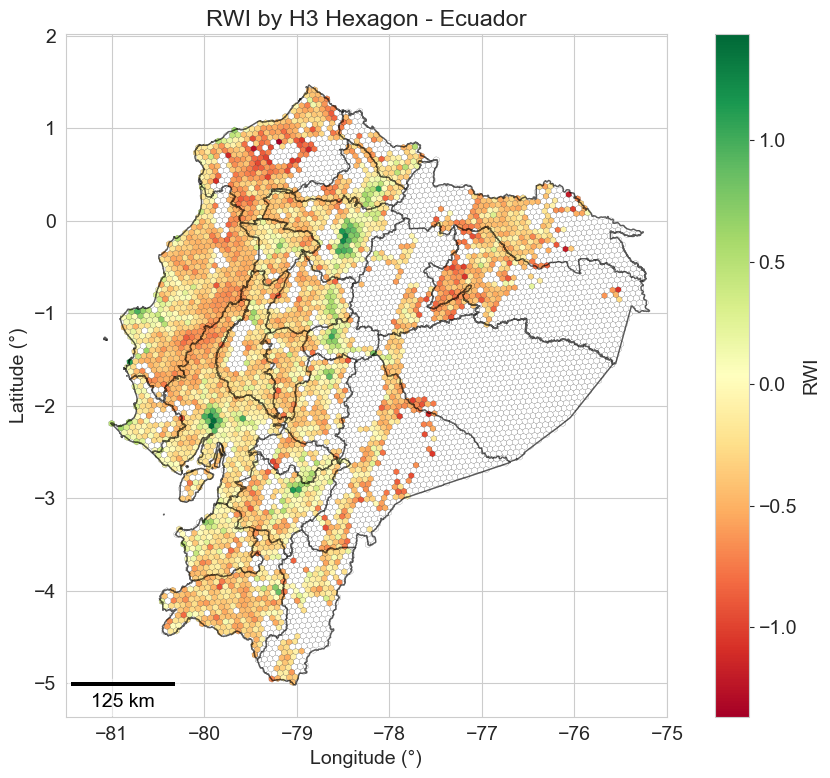

In [83]:
#plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(10, 8))

hexagons.plot(
    column='rwi_mean',
    ax=ax,
    legend=True,
    cmap='RdYlGn',
    edgecolor='black',
    linewidth=0.1,
    missing_kwds={'color': 'white', 'label': 'No data'},
    legend_kwds={"label": "RWI"}
)


admin_gdf.plot(ax=ax, edgecolor='black', color='None', alpha=0.4)
region_gdf.plot(ax=ax, edgecolor='black', color='None', alpha=0.4)

ax.set_aspect('equal')
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')
ax.set_title('RWI by H3 Hexagon - Ecuador')
ax.set_xlim(-81.5, -75)

# Add scale bar using the calculated distance_meters
scalebar = ScaleBar(
    distance_meters,        # meters per degree at Ecuador's latitude
    dimension="si-length",
    location='lower left',
    length_fraction=0.2,
    width_fraction=0.005,
    units='m',
    color='black',
    box_alpha=0.5
)

ax.add_artist(scalebar)

plt.tight_layout()
#plt.savefig('../outputs/fig/rwi_map_ecuador.png', dpi=300, bbox_inches='tight')
#plt.savefig('../images/rwi_map_ecuador.png', dpi=300, bbox_inches='tight')
plt.show()

# 3 Load parroquia shapefile and voting data

In [53]:
# Load voting data
votos = pd.read_csv("../cne_web_scrp/resultados_referendum_20251119_190005.csv")

print(f"Loaded {len(votos)} voting records")
print(votos.head(5))

Loaded 10336 voting records
   provincia_id provincia  canton_id                 canton  parroquia_id  \
0             1     AZUAY        556  CAMILO PONCE ENRIQUEZ          6875   
1             1     AZUAY        556  CAMILO PONCE ENRIQUEZ          6875   
2             1     AZUAY        556  CAMILO PONCE ENRIQUEZ          6875   
3             1     AZUAY        556  CAMILO PONCE ENRIQUEZ          6875   
4             1     AZUAY        556  CAMILO PONCE ENRIQUEZ          6875   

               parroquia  intCodDignidad  strOrdPartido  intCodPartido  \
0  CAMILO PONCE ENRIQUEZ              25              1           9925   
1  CAMILO PONCE ENRIQUEZ              25              2           9925   
2  CAMILO PONCE ENRIQUEZ              26              1           9926   
3  CAMILO PONCE ENRIQUEZ              26              2           9926   
4  CAMILO PONCE ENRIQUEZ              27              1           9927   

              strNomPartido strLisPartido strNomCandidato  intVo

## 3.1 Map provinces to H3 hexagons

In [54]:
# Function to get all H3 indices covering a polygon
def polygon_to_h3(geometry, resolution):
    """Convert a polygon to H3 indices"""
    # Get the exterior coordinates
    if geometry.geom_type == 'Polygon':
        coords = list(geometry.exterior.coords)
    elif geometry.geom_type == 'MultiPolygon':
        # For multipolygons, use the largest polygon
        coords = list(max(geometry.geoms, key=lambda p: p.area).exterior.coords)
    else:
        return []
    
    # Convert to H3 format: list of [lat, lon] pairs
    h3_coords = [[lat, lon] for lon, lat in coords]
    
    # Get H3 indices using polyfill
    try:
        h3_indices = h3.polyfill_geojson(
            {
                'type': 'Polygon',
                'coordinates': [[list(coord) for coord in coords]]
            },
            resolution
        )
        return list(h3_indices)
    except:
        # Fallback: use centroid
        centroid = geometry.centroid
        return [h3.latlng_to_cell(centroid.y, centroid.x, resolution)]

# Map each parroquia to H3 indices
parroquia_h3_list = []

for idx, row in admin_gdf.iterrows():
    h3_indices = polygon_to_h3(row.geometry, size)
    for h3_idx in h3_indices:
        parroquia_h3_list.append({
            #'parroquia_id': row['GID_2'],  # adjust field name
            'provincia': row['NAME_1'],      # adjust field name
            'h3_index': h3_idx
        })

parroquia_h3 = pd.DataFrame(parroquia_h3_list)
parroquia_h3["provincia"]= parroquia_h3["provincia"].str.upper()

print(f"Mapped {len(parroquia_h3)} H3 hexagons to provinces")
parroquia_h3.head(5)

Mapped 24 H3 hexagons to provinces


,provincia,h3_index
0,AZUAY,868f76c77ffffff
1,BOLIVAR,868f29d27ffffff
2,CAÑAR,868f29627ffffff
3,CARCHI,8666d026fffffff
4,CHIMBORAZO,868f298c7ffffff


## 3.2 Process voting data

In [55]:
# Aggregate votes by parroquia and question
votos_parr = votos.groupby(['provincia_id', 'provincia', 'intCodDignidad']).apply(
    lambda x: pd.Series({
        'total_votes': x['intVotos'].sum(),
        'yes_votes': x[x['strNomCandidato'] == 'SI']['intVotos'].sum(),
        'no_votes': x[x['strNomCandidato'] == 'NO']['intVotos'].sum()
    })
).reset_index()

votos_parr['yes_pct'] = (votos_parr['yes_votes'] / votos_parr['total_votes']) * 100

# Map question codes to names
question_map = {
    25: 'Q1',
    26: 'Q2',
    27: 'Q3',  # adjust based on your data
    28: 'Q4'
}

votos_parr['question'] = votos_parr['intCodDignidad'].map(question_map)

# Pivot to wide format
votos_wide = votos_parr.pivot_table(
    index=['provincia_id', 'provincia'],
    columns='question',
    values=['yes_pct', 'total_votes']
).reset_index()

# Flatten column names
votos_wide.columns = ['_'.join(col).strip('_') for col in votos_wide.columns.values]

print(votos_wide.head())

   provincia_id provincia  total_votes_Q1  total_votes_Q2  total_votes_Q3  \
0             1     AZUAY        464091.0        463305.0        463602.0   
1             2   BOLIVAR        138688.0        138124.0        137998.0   
2             3     CAÑAR        134042.0        133637.0        133574.0   
3             4    CARCHI        121378.0        121053.0        121113.0   
4             5  COTOPAXI        308935.0        308076.0        307838.0   

   total_votes_Q4  yes_pct_Q1  yes_pct_Q2  yes_pct_Q3  yes_pct_Q4  
0        454528.0   38.754037   42.520802   48.804362   36.355956  
1        133531.0   37.365886   39.780921   45.714431   36.393796  
2        129602.0   40.729771   43.303127   48.863551   39.274857  
3        118276.0   35.517969   39.407532   45.179295   33.958707  
4        299071.0   33.154871   36.637713   43.164911   32.838690  


C:\Users\rheredia\AppData\Local\Temp\ipykernel_22224\2507518197.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  votos_parr = votos.groupby(['provincia_id', 'provincia', 'intCodDignidad']).apply(


In [56]:
# ccheck final dataframes
print("parroquia_h3 columns:", parroquia_h3.columns.tolist())
print(parroquia_h3.head())

print("\nvotos_wide columns:", votos_wide.columns.tolist())
print(votos_wide.head())

parroquia_h3 columns: ['provincia', 'h3_index']
    provincia         h3_index
0       AZUAY  868f76c77ffffff
1     BOLIVAR  868f29d27ffffff
2       CAÑAR  868f29627ffffff
3      CARCHI  8666d026fffffff
4  CHIMBORAZO  868f298c7ffffff

votos_wide columns: ['provincia_id', 'provincia', 'total_votes_Q1', 'total_votes_Q2', 'total_votes_Q3', 'total_votes_Q4', 'yes_pct_Q1', 'yes_pct_Q2', 'yes_pct_Q3', 'yes_pct_Q4']
   provincia_id provincia  total_votes_Q1  total_votes_Q2  total_votes_Q3  \
0             1     AZUAY        464091.0        463305.0        463602.0   
1             2   BOLIVAR        138688.0        138124.0        137998.0   
2             3     CAÑAR        134042.0        133637.0        133574.0   
3             4    CARCHI        121378.0        121053.0        121113.0   
4             5  COTOPAXI        308935.0        308076.0        307838.0   

   total_votes_Q4  yes_pct_Q1  yes_pct_Q2  yes_pct_Q3  yes_pct_Q4  
0        454528.0   38.754037   42.520802   48.804362   

## 3.3 Join parroquia votes to H3

In [57]:
# Merge parroquia votes with H3 mapping
votos_h3 = parroquia_h3.merge(votos_wide, on='provincia', how='left')

print(f"Voting data mapped to {len(votos_h3)} H3 hexagons")

Voting data mapped to 24 H3 hexagons


In [58]:
votos_h3

,provincia,h3_index,provincia_id,total_votes_Q1,total_votes_Q2,total_votes_Q3,total_votes_Q4,yes_pct_Q1,yes_pct_Q2,yes_pct_Q3,yes_pct_Q4
0,AZUAY,868f76c77ffffff,1.0,464091.0,463305.0,463602.0,454528.0,38.754037,42.520802,48.804362,36.355956
1,BOLIVAR,868f29d27ffffff,2.0,138688.0,138124.0,137998.0,133531.0,37.365886,39.780921,45.714431,36.393796
2,CAÑAR,868f29627ffffff,3.0,134042.0,133637.0,133574.0,129602.0,40.729771,43.303127,48.863551,39.274857
3,CARCHI,8666d026fffffff,4.0,121378.0,121053.0,121113.0,118276.0,35.517969,39.407532,45.179295,33.958707
4,CHIMBORAZO,868f298c7ffffff,6.0,312786.0,311707.0,311452.0,301006.0,42.828643,46.605947,52.153462,42.125738
5,COTOPAXI,868f2dc4fffffff,5.0,308935.0,308076.0,307838.0,299071.0,33.154871,36.637713,43.164911,32.838690
6,EL ORO,868f0d857ffffff,7.0,428260.0,427607.0,427870.0,418403.0,41.330500,43.848206,48.599107,41.321644
7,ESMERALDAS,8666d2af7ffffff,8.0,312684.0,311176.0,310346.0,297485.0,35.678832,35.936576,39.253285,34.638385
8,GALÁPAGOS,866c5b89fffffff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,GUAYAS,868f2b9a7ffffff,9.0,2556016.0,2551517.0,2551283.0,2494828.0,40.879478,42.191214,46.008263,39.734403


# 4 Join RWI with voting data

In [59]:
# Merge RWI and voting data by H3 index
analysis_data = votos_h3.merge(rwi_h3, on='h3_index', how='inner')

print(f"Final analysis dataset: {len(analysis_data)} H3 hexagons")
print(f"Missing RWI: {votos_h3['h3_index'].isin(rwi_h3['h3_index']).sum()}")

# Remove duplicates (if any)
analysis_data = analysis_data.drop_duplicates(subset='h3_index')

print(analysis_data.head())

Final analysis dataset: 14 H3 hexagons
Missing RWI: 14
    provincia         h3_index  provincia_id  total_votes_Q1  total_votes_Q2  \
0       AZUAY  868f76c77ffffff           1.0        464091.0        463305.0   
1     BOLIVAR  868f29d27ffffff           2.0        138688.0        138124.0   
2       CAÑAR  868f29627ffffff           3.0        134042.0        133637.0   
3  CHIMBORAZO  868f298c7ffffff           6.0        312786.0        311707.0   
4    COTOPAXI  868f2dc4fffffff           5.0        308935.0        308076.0   

   total_votes_Q3  total_votes_Q4  yes_pct_Q1  yes_pct_Q2  yes_pct_Q3  \
0        463602.0        454528.0   38.754037   42.520802   48.804362   
1        137998.0        133531.0   37.365886   39.780921   45.714431   
2        133574.0        129602.0   40.729771   43.303127   48.863551   
3        311452.0        301006.0   42.828643   46.605947   52.153462   
4        307838.0        299071.0   33.154871   36.637713   43.164911   

   yes_pct_Q4  rwi_mean  

## 4.1 Create wealth groups

In [60]:
# Create tertiles and quintiles
analysis_data['rwi_tertile'] = pd.qcut(
    analysis_data['rwi_mean'], 
    q=3, 
    labels=['Low wealth', 'Medium wealth', 'High wealth']
)

analysis_data['rwi_quintile'] = pd.qcut(
    analysis_data['rwi_mean'], 
    q=5, 
    labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
)

In [61]:
analysis_data

,provincia,h3_index,provincia_id,total_votes_Q1,total_votes_Q2,total_votes_Q3,total_votes_Q4,yes_pct_Q1,yes_pct_Q2,yes_pct_Q3,yes_pct_Q4,rwi_mean,rwi_median,rwi_sd,n_points,rwi_tertile,rwi_quintile
0,AZUAY,868f76c77ffffff,1.0,464091.0,463305.0,463602.0,454528.0,38.754037,42.520802,48.804362,36.355956,0.512000,0.5120,NaN,1,High wealth,Q5
1,BOLIVAR,868f29d27ffffff,2.0,138688.0,138124.0,137998.0,133531.0,37.365886,39.780921,45.714431,36.393796,-0.359000,-0.3590,0.195161,2,Low wealth,Q2
2,CAÑAR,868f29627ffffff,3.0,134042.0,133637.0,133574.0,129602.0,40.729771,43.303127,48.863551,39.274857,-0.045200,-0.1680,0.502666,5,Medium wealth,Q4
3,CHIMBORAZO,868f298c7ffffff,6.0,312786.0,311707.0,311452.0,301006.0,42.828643,46.605947,52.153462,42.125738,-0.153167,-0.1005,0.467167,6,Medium wealth,Q3
4,COTOPAXI,868f2dc4fffffff,5.0,308935.0,308076.0,307838.0,299071.0,33.154871,36.637713,43.164911,32.838690,-0.487167,-0.5200,0.151253,6,Low wealth,Q1
5,EL ORO,868f0d857ffffff,7.0,428260.0,427607.0,427870.0,418403.0,41.330500,43.848206,48.599107,41.321644,-0.412500,-0.4125,0.101116,2,Low wealth,Q1
6,GUAYAS,868f2b9a7ffffff,9.0,2556016.0,2551517.0,2551283.0,2494828.0,40.879478,42.191214,46.008263,39.734403,0.888833,0.8510,0.280454,6,High wealth,Q5
7,LOJA,868f0d347ffffff,11.0,304705.0,303925.0,304218.0,295409.0,47.528593,51.948343,57.951535,46.928157,-0.330000,-0.2980,0.186665,7,Medium wealth,Q2
8,LOS RIOS,868f28ba7ffffff,12.0,562187.0,560400.0,560042.0,541362.0,34.121387,34.734832,38.341767,33.532276,-0.529167,-0.4265,0.214046,6,Low wealth,Q1
9,MANABI,868f2eb4fffffff,13.0,1026646.0,1023489.0,1021937.0,986275.0,29.391046,30.443219,33.419868,28.228942,-0.117286,-0.0760,0.203465,7,Medium wealth,Q3


## 4.2 Descriptive analysis

In [62]:
# Summary by wealth group
summary = analysis_data.groupby('rwi_tertile').agg({
    'h3_index': 'count',
    'yes_pct_Q1': 'mean',
    'yes_pct_Q2': 'mean',
    'yes_pct_Q3': 'mean',
    'yes_pct_Q4': 'mean'
}).round(2)

summary.columns = ['n_hexagons', 'Q1_yes_avg', 'Q2_yes_avg', 'Q3_yes_avg', 'Q4_yes_avg']
print("\nVoting patterns by wealth group:")
print(summary)

# Correlations
corr_cols = ['rwi_mean', 'yes_pct_Q1', 'yes_pct_Q2', 'yes_pct_Q3', 'yes_pct_Q4']
correlations = analysis_data[corr_cols].corr()['rwi_mean'].drop('rwi_mean')
print("\nCorrelations with RWI:")
print(correlations)


Voting patterns by wealth group:
               n_hexagons  Q1_yes_avg  Q2_yes_avg  Q3_yes_avg  Q4_yes_avg
rwi_tertile                                                              
Low wealth              5       34.50       36.75       41.84       34.18
Medium wealth           4       40.12       43.08       48.10       39.14
High wealth             5       43.79       47.27       52.74       42.22

Correlations with RWI:
yes_pct_Q1    0.282445
yes_pct_Q2    0.254945
yes_pct_Q3    0.225839
yes_pct_Q4    0.222850
Name: rwi_mean, dtype: float64


C:\Users\rheredia\AppData\Local\Temp\ipykernel_22224\306575982.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = analysis_data.groupby('rwi_tertile').agg({


### Visualization

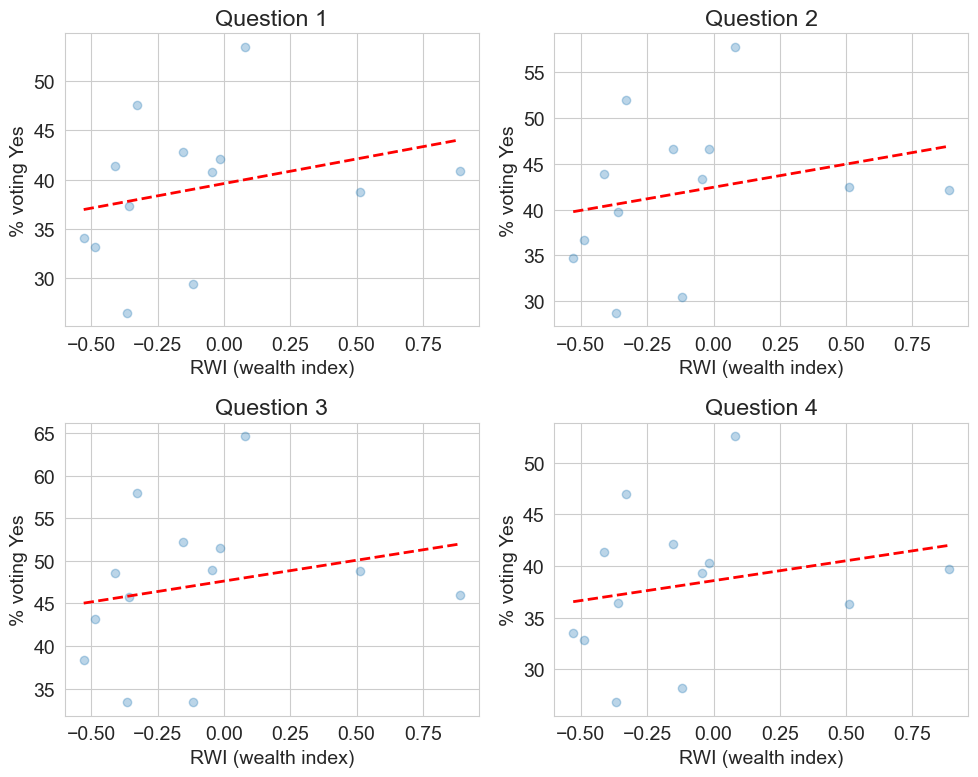

In [63]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
questions = ['Q1', 'Q2', 'Q3', 'Q4']

for ax, q in zip(axes.flat, questions):
    col = f'yes_pct_{q}'
    if col not in analysis_data.columns:
        ax.set_title(f"{q} (no data)")
        ax.axis('off')
        continue

    # Drop rows with any NaN in rwi_mean or this yes column
    df_q = analysis_data[['rwi_mean', col]].dropna()
    if df_q.empty:
        ax.set_title(f"{q} (no non-missing data)")
        ax.axis('off')
        continue

    # Scatter
    ax.scatter(df_q['rwi_mean'], df_q[col], alpha=0.3)

    # Trend line (only if we have enough points)
    if len(df_q) >= 3:
        z = np.polyfit(df_q['rwi_mean'], df_q[col], 1)
        p = np.poly1d(z)
        x_sorted = np.sort(df_q['rwi_mean'])
        ax.plot(x_sorted, p(x_sorted), "r--", linewidth=2)

    ax.set_xlabel('RWI (wealth index)')
    ax.set_ylabel('% voting Yes')
    ax.set_title(f'Question {q[-1]}')

plt.tight_layout()
plt.savefig('../outputs/fig/rwi_voting_scatterplots.png', dpi=300, bbox_inches='tight')
plt.show()

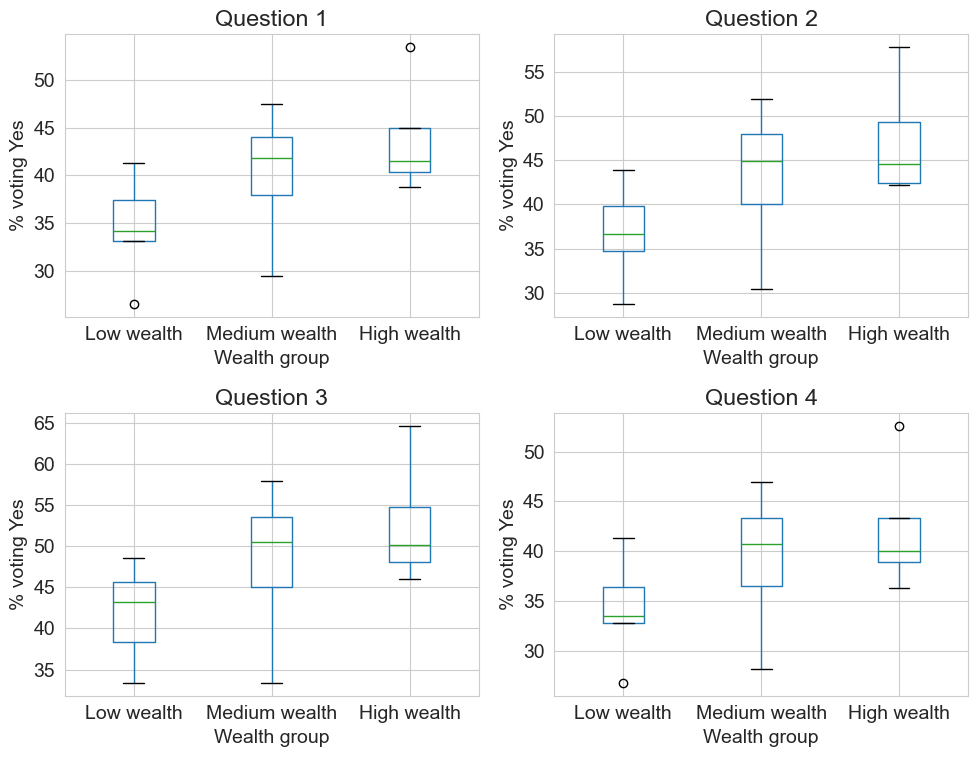

In [64]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for ax, q in zip(axes.flat, questions):
    col = f'yes_pct_{q}'
    if col not in analysis_data.columns:
        ax.set_title(f"{q} (no data)")
        ax.axis('off')
        continue

    df_q = analysis_data[['rwi_tertile', col]].dropna()
    if df_q.empty:
        ax.set_title(f"{q} (no non-missing data)")
        ax.axis('off')
        continue

    df_q.boxplot(column=col, by='rwi_tertile', ax=ax)
    ax.set_xlabel('Wealth group')
    ax.set_ylabel('% voting Yes')
    ax.set_title(f'Question {q[-1]}')

plt.suptitle("")  # remove global title added by pandas
plt.tight_layout()
plt.savefig('../outputs/fig/rwi_voting_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

# 5 Regression models

In [67]:
# Weighted linear regression for each question
results_list = []

for q in questions:
    yes_col = f'yes_pct_{q}'
    votes_col = f'total_votes_{q}'
    
    if yes_col in analysis_data.columns and votes_col in analysis_data.columns:
        # Prepare data
        df_model = analysis_data[[yes_col, 'rwi_mean', votes_col]].dropna()
        
        X = sm.add_constant(df_model['rwi_mean'])
        y = df_model[yes_col]
        weights = df_model[votes_col]
        
        # Fit weighted least squares
        model = sm.WLS(y, X, weights=weights).fit()
        
        results_list.append({
            'Question': q,
            'Coefficient': model.params['rwi_mean'],
            'Std Error': model.bse['rwi_mean'],
            'P-value': model.pvalues['rwi_mean'],
            'R-squared': model.rsquared
        })
        
        print(f"\n{q} Regression Results:")
        print(model.summary())

# Create results table
results_df = pd.DataFrame(results_list)
print("\nSummary of all models:")
print(results_df)

# Save results
results_df.to_csv('../outputs/regression_results.csv', index=False)


Q1 Regression Results:
                            WLS Regression Results                            
Dep. Variable:             yes_pct_Q1   R-squared:                       0.067
Model:                            WLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.7897
Date:                Thu, 25 Dec 2025   Prob (F-statistic):              0.393
Time:                        14:45:38   Log-Likelihood:                -43.277
No. Observations:                  13   AIC:                             90.55
Df Residuals:                      11   BIC:                             91.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.0503      1

Summary of Findings
Across all four questions, the analysis shows no statistically significant relationship between a household's relative wealth (RWI) and their likelihood of voting "Yes." While the coefficients are positive, the high p-values and low R-squared values suggest that wealth is not a primary driver of voting behavior for these specific questions.

1. Lack of Statistical Significance
All four questions have P-values well above the standard 0.05 threshold (ranging from 0.39 to 0.77). This means we cannot conclude that wealthier areas voted differently than poorer areas. The observed differences are likely due to random chance rather than a systematic wealth effect.

2. Direction of the Relationship (Coefficients)
The coefficients for all questions are positive (e.g., 2.82 for Q1, 2.42 for Q4). This suggests a slight tendency for wealthier areas to vote "Yes" more often, but because the Standard Errors are larger than the coefficients themselves, these estimates are very imprecise and unreliable.

3. Low Explanatory Power (R-squared)
The R-squared values are extremely low (between 0.007 and 0.067). This indicates that wealth (RWI) explains less than 7% of the variation in voting patterns. Other factors—such as political affiliation, regional identity, or specific local concerns—are likely far more important in determining how people voted.

Implications
Cross-Class Consensus or Polarization: The lack of a wealth-based divide suggests that these ballot questions did not split the country along economic lines. Both affluent and less-affluent households likely evaluated the questions based on non-economic criteria.
Policy Neutrality: If these questions were related to security or institutional reform, the results imply that support (or opposition) for these measures was relatively uniform across different socioeconomic strata.
Need for Further Variables: To better understand the vote, future analysis should look at variables beyond wealth, such as urban vs. rural location, education levels, or province-specific political trends.

Conceptually symmetric check to your current model

In [66]:
analysis_data['rwi_group'] = pd.qcut(
    analysis_data['rwi_mean'],
    q=3,
    labels=['Low wealth', 'Medium wealth', 'High wealth']
)

analysis_data.groupby('rwi_group')['yes_pct_Q1'].mean()

C:\Users\rheredia\AppData\Local\Temp\ipykernel_22224\64498105.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis_data.groupby('rwi_group')['yes_pct_Q1'].mean()


rwi_group
Low wealth       34.497416
Medium wealth    40.119513
High wealth      43.792604
Name: yes_pct_Q1, dtype: float64

Regression --> “no effect of RWI”, these three means should be fairly similar for each question (differences small and within sampling noise).